In [1]:
import numpy
from matplotlib import colors
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import minimize

In [2]:
# Register the color map to be used for plotting.
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

In [10]:
# Read the data from the problem 3 file.
from numpy import genfromtxt
my_data = genfromtxt('logistic_regression.csv', delimiter=',', skip_header=1)
print(my_data.shape)
X = my_data[:, [0, 1]]
y = my_data[:, 2]

# Divide the data into two classes for plotting.
X0 = my_data[numpy.where(my_data[:, 2] == 0)]
X1 = my_data[numpy.where(my_data[:, 2] == 1)] 

(2000, 3)


In [11]:
# Implements the natural log of the logistic function on $w^T x$.
def log_logistic_prob(iterate, x):
    t = numpy.dot(iterate[1:], x) + iterate[0]
    if t < -33:
        return t
    elif t < -18:
        return t - numpy.exp(t)
    elif t < 37:
        return -numpy.log1p(numpy.exp(- t ))
    else:
        return -numpy.exp(-t)

# Implements the logistic function on $w^T x$.

# exponential embedded diff to implement
def logistic_prob(iterate, x):
    t = numpy.dot(iterate[1:], x) + iterate[0]
    if t < -33.3:# very small number thres
        return numpy.exp(t)
    elif t <= -18:
        return numpy.exp(t - numpy.exp(t))
    elif t <= 37:
        return numpy.exp(-numpy.log1p(numpy.exp(-t)))
    else:
        return numpy.exp(-numpy.exp(-t))

In [12]:
# Evaluates the logistic function on a set of grid points.
def logistic_prob_grid(iterate, grids):
    return numpy.array([logistic_prob(iterate, x) for x in grids ])

# Takes the logistic probability and thresholds to outputs a classification label.
def logistic_pred(iterate, x):
    return 1.0 if logistic_prob(iterate, x) > 0.5 else 0.0

In [117]:
# Implements the negative logistic regression objective. Modify me!
def negative_log_likelihood(iterate, X, y, regularization):
    #print(iterate) 
    # The accumulated objective value.
    obj_val = 0.0
        
    # Loop over each (x, y) pair.
    for i, (x_vec, y) in enumerate(zip(X, y)):
            
        # Dot product $w^T x$.            
        predict = iterate[0] + numpy.dot(iterate[1:], x_vec)
            
        # Accumulate the objective value contribution from this (x, y) pair.
        obj_val += ((1 - y) * (log_logistic_prob(iterate, x_vec) - predict) + (y) * log_logistic_prob(iterate, x_vec) )
        
    # Subtract the regularization parameter.
    return - obj_val + regularization * numpy.dot(iterate[2], iterate[2])

In [118]:
# Implements the logistic regression gradient. Modify me!
def gradient_negative_log_likelihood(iterate, X, y, regularization):
    gradient = numpy.zeros(3)
    
    # Loop over each (x, y) pair. 
    for i, (x_vec, y) in enumerate(zip(X, y)):
        
        # Dot product $w^T x$.            
        predict = iterate[0] + numpy.dot(iterate[1:], x_vec)
        
        if predict > 0.0: # predicted label = 1
            factor = ((1-y) + (-y) * numpy.exp(-predict)) / ( 1 + numpy.exp(-predict) )
        else: # predicted label = 0
            factor = (( -y) + numpy.exp(predict)*(1-y) ) / ( 1 + numpy.exp(predict) )
        gradient[0] += factor
        gradient[1:] += factor * x_vec
        
    # Regularize gradient.
    gradient[1:] += 2 * regularization * iterate[2]
    
    return gradient 

In [129]:
# Plots the data with the decision boundary.
def plot_data(X, y, iterate, regularization):
    y_pred = [logistic_pred(iterate, x) for x in X]
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 200
    x_min, x_max = (-10, 10)
    y_min, y_max = (-10, 10)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    xx, yy = numpy.meshgrid(numpy.linspace(x_min, x_max, nx),
                         numpy.linspace(y_min, y_max, ny))

    Z = logistic_prob_grid(iterate, numpy.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    neg_log_likelihood = negative_log_likelihood(iterate, X, y, regularization)
    plt.title(
        'Negative log likelihood: ' + str(neg_log_likelihood)+'\n No Regularization')
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    
    # Plot my linear decision boundary here!
   # x_min, x_max = ax1.get_xlim()
   
    
    #plt.contourf(xx, yy, Z, cmap=cmap, vmin=Z.min(), vmax=Z.max(),
     #        levels=numpy.linspace(Z.min(), Z.max(), 50))
   # plt.contour(xx, yy, Z, levels=[0], linestyles='dashed')
    #plt.axis("tight")
    #ax1.plot([0, x_max], [intercept1, x_max*slope1+intercept1])
    x0 = numpy.linspace(x_min, x_max);
    y0 = -(iterate[1]/iterate[2])*x0 - (iterate[0]/iterate[2]);
    plt.plot(x_min, x_max, 'b.', x0, y0, color='green', linewidth=4, linestyle=':');
    plt.savefig('no_regularization.png')
    plt.show()

[ 3.23590837 -9.93360143 -8.96433525]


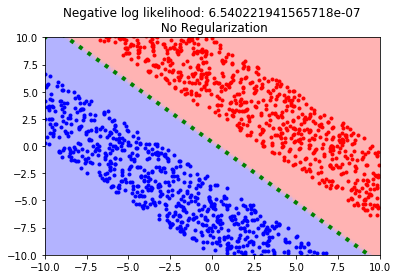

In [130]:
# Plot for each different regularization value by calling your optimization routine for
# different values.
initial_iterate = [0,0,0]
regularization = 0
results =  minimize(fun = negative_log_likelihood, x0 = initial_iterate, args = (X,y, regularization), jac = gradient_negative_log_likelihood)
iterate = results.x
print(iterate)

plot_data(X, y, iterate, 0)